<a href="https://colab.research.google.com/github/brymer-meneses/chloroplast/blob/main/machine_learning/model_training/apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites


In [1]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 6.3MB/s 


In [2]:
!pip install mlxtend --upgrade --no-deps

     |████████████████████████████████| 1.4MB 6.6MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [3]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import os 
import shutil

from zipfile import ZipFile
from os.path import join
from os import listdir
from google.colab import drive

import math 
import random 

In [4]:
drive.mount('drive', force_remount=True)

Mounted at drive


# File Structuring

In [5]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded

--2021-03-10 12:35:55--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066 [following]
--2021-03-10 12:35:55--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.85.27
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.85.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 868032562 (828M) [application

In [6]:
os.rename('file_downloaded', "plantvillage_ds.zip")
with ZipFile('plantvillage_ds.zip', 'r') as file:
  file.extractall()

os.remove('plantvillage_ds.zip')
os.rename('/content/Plant_leave_diseases_dataset_without_augmentation', "/content/dataset")

In [7]:
# Plants to be deleted 
def delete_plants(dataset_plant):
  dataset_dir = "/content/dataset"
  for plant in os.listdir(dataset_dir):

    # Skip the folder 'Background_without_leaves" since it 
    # will serve as the non-informative class

    if plant == "Background_without_leaves":
      continue
    
    elif not dataset_plant in plant.lower():
      
      shutil.rmtree(join(dataset_dir, plant))
  return

In [8]:
def train_val_test_split(source_dir, destination_dir, data_split=[0.6, 0.2, 0.2]):

  """Copies the file structure of a directory and splits it for 
  train, test, validation.

  source_dir/
    ├─ folder1/
    ├─ folder2/
    ├─ .../

  destination_dir/
    |
    ├─ train/
    │   ├─ folder1/
    │   ├─ folder2/
    │   ├─ .../
    │
    ├─ test/
    │   ├─ folder1/
    │   ├─ folder2/
    │   ├─ .../
    |
    ├─ val/
    │   ├─ folder1/
    │   ├─ folder2/
    │   ├─ .../

  
  """
  assert float(data_split[0] + data_split[1] + data_split[2]) == 1.0, "Data Split must be equal to 1"
  if not os.path.isdir(destination_dir):
    os.mkdir(destination_dir)
  
  dirs = ["train", "val", "test"]

  for dir in dirs:
    try:
      os.mkdir(os.path.join(destination_dir, dir))
    except Exception as e:
      print(e)

    for plant_type in os.listdir(source_dir):
      try:
        os.mkdir(os.path.join(destination_dir, dir, plant_type))
      except Exception as e:
        print(e)

  
  def split(source, destination, total):
    counter = 0
    while not counter == total:
      random_image = random.choice(os.listdir(source))
      image_source = os.path.join(source, random_image)
     
      image_destination = os.path.join(destination, random_image)

      shutil.move(image_source, image_destination)

      counter += 1
    return

  for folder in os.listdir(source_dir):
    
  
    total_images = len(os.listdir(os.path.join(source_dir, folder)))
    train_total = math.floor(total_images * data_split[0])
    test_total = math.floor(total_images * data_split[1])
    val_total = math.floor(total_images * data_split[2])

    split(join(source_dir, folder), os.path.join(destination_dir, "train", folder), train_total)
    split(join(source_dir, folder), os.path.join(destination_dir, "test", folder), test_total)
    split(join(source_dir, folder), os.path.join(destination_dir, "val", folder), val_total)

    print(f"Successfully splitted data from {os.path.join(source_dir, folder)} {os.path.join(destination_dir, folder)}")
    print(f"\t - Train Images: {train_total}")
    print(f"\t - Val Images: {val_total}")
    print(f"\t - Test Images: {train_total}")
    
  return 



In [9]:
def normalize_dataset(dataset_path, normalize_path, plant_name):
  """ Normalizes the number of images 
      from a certain class of a dataset  """
  plant_count = []
  print(f'Before Normalization: {len(os.listdir(normalize_path))}\n')

  for folder in os.listdir(dataset_path):
    if plant_name in folder.lower():
      plant_folder = os.path.join(dataset_path, plant_name)
      plant_images_total = len(os.listdir(os.path.join(dataset_path, folder)))

      plant_count.append(plant_images_total)
      print(f'{folder} total: {plant_images_total}')

  average = math.floor(np.sum(plant_count) / len(plant_count))
  print(f'\nAverage: {average}')
  
  while len(os.listdir(normalize_path)) != average:
    random_image = random.choice(os.listdir(normalize_path))
    random_image_path = os.path.join(normalize_path, random_image)
    os.remove(random_image_path)
  
  print(f'After Normalization: {len(os.listdir(normalize_path))}')
  return 

    

# Model Training

In [10]:
delete_plants("apple")


In [11]:
normalize_dataset('/content/dataset', '/content/dataset/Background_without_leaves', 'apple')

Before Normalization: 1143

Apple___Black_rot total: 621
Apple___healthy total: 1645
Apple___Cedar_apple_rust total: 275
Apple___Apple_scab total: 630

Average: 792
After Normalization: 792


In [12]:
train_val_test_split("/content/dataset", "/content/split")

Successfully splitted data from /content/dataset/Background_without_leaves /content/split/Background_without_leaves
	 - Train Images: 475
	 - Val Images: 158
	 - Test Images: 475
Successfully splitted data from /content/dataset/Apple___Black_rot /content/split/Apple___Black_rot
	 - Train Images: 372
	 - Val Images: 124
	 - Test Images: 372
Successfully splitted data from /content/dataset/Apple___healthy /content/split/Apple___healthy
	 - Train Images: 987
	 - Val Images: 329
	 - Test Images: 987
Successfully splitted data from /content/dataset/Apple___Cedar_apple_rust /content/split/Apple___Cedar_apple_rust
	 - Train Images: 165
	 - Val Images: 55
	 - Test Images: 165
Successfully splitted data from /content/dataset/Apple___Apple_scab /content/split/Apple___Apple_scab
	 - Train Images: 378
	 - Val Images: 126
	 - Test Images: 378


In [13]:
from tensorflow.keras.models import load_model, save_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation

import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

In [14]:
# We will fine-tune EfficientLite-Lite4
img_size = 380
batch_size = 64

train_dir = "/content/split/train"
val_dir = "/content/split/val"
test_dir = "/content/split/test"

In [15]:
# Data Split
# Training Data - 60%
# Validation Data - 20%
# Test Data - 20%

datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [0.7, 1.3],
    zoom_range = [0.9, 1.1],
    rescale = 1/255,
)

train_gen = datagen.flow_from_directory(
    train_dir, 
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True,
)

test_gen = datagen.flow_from_directory(
    test_dir, 
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = False,
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True,
)


Found 2377 images belonging to 5 classes.
Found 792 images belonging to 5 classes.
Found 792 images belonging to 5 classes.


In [16]:
URL = 'https://tfhub.dev/tensorflow/efficientnet/lite4/feature-vector/2'
pretrained_model = hub.KerasLayer(URL, input_shape = (img_size, img_size,3))

In [17]:
model = Sequential(name="apple")
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(.30))
model.add(Dense(len(train_gen.class_indices), activation = 'softmax'))

training_model = Sequential([
                             pretrained_model, 
                             model
])

In [18]:
training_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              11837936  
_________________________________________________________________
apple (Sequential)           (None, 5)                 658437    
Total params: 12,496,373
Trainable params: 658,437
Non-trainable params: 11,837,936
_________________________________________________________________


In [19]:
f1_score = F1Score(len(train_gen.class_indices))

In [20]:
training_model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy', f1_score])
es = EarlyStopping(monitor = 'val_loss', patience =3)

In [21]:
training_history = training_model.fit(train_gen, validation_data= val_gen, epochs = 5, callbacks = es)

Epoch 1/5
38/38 [==============================] - 150s 3s/step - loss: 0.6732 - accuracy: 0.7483 - f1_score: 0.6561 - val_loss: 0.1546 - val_accuracy: 0.9508 - val_f1_score: 0.9372
Epoch 2/5
38/38 [==============================] - 116s 3s/step - loss: 0.1537 - accuracy: 0.9507 - f1_score: 0.9331 - val_loss: 0.1033 - val_accuracy: 0.9646 - val_f1_score: 0.9599
Epoch 3/5
38/38 [==============================] - 116s 3s/step - loss: 0.1163 - accuracy: 0.9590 - f1_score: 0.9451 - val_loss: 0.0949 - val_accuracy: 0.9634 - val_f1_score: 0.9584
Epoch 4/5
38/38 [==============================] - 117s 3s/step - loss: 0.0776 - accuracy: 0.9754 - f1_score: 0.9669 - val_loss: 0.0926 - val_accuracy: 0.9672 - val_f1_score: 0.9579
Epoch 5/5
38/38 [==============================] - 116s 3s/step - loss: 0.0738 - accuracy: 0.9776 - f1_score: 0.9733 - val_loss: 0.0514 - val_accuracy: 0.9811 - val_f1_score: 0.9797


In [22]:
os.chdir("/content/drive/MyDrive/Research/models")
model.save("apple.h5")

# Model Training Analytics



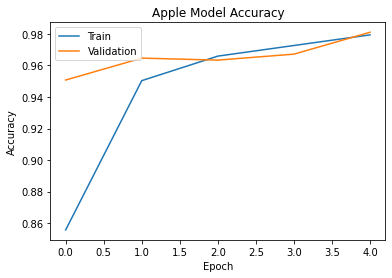

In [23]:
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Apple Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()


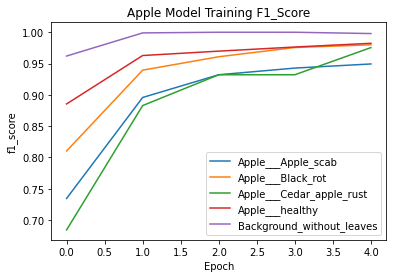

In [24]:

plt.plot(training_history.history['f1_score'])
plt.title('Apple Model Training F1_Score')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(train_gen.class_indices.keys(), loc = 'lower right')
plt.show()


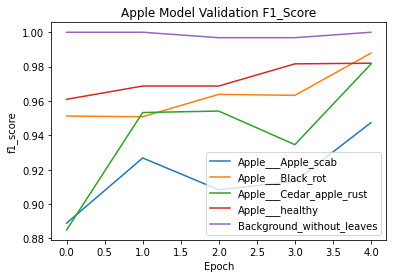

In [25]:
plt.plot(training_history.history['val_f1_score'])
plt.title('Apple Model Validation F1_Score')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(train_gen.class_indices.keys(), loc = 'lower right')
plt.show()


# Model Testing Analytics

In [26]:
from mlxtend.plotting import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix

In [27]:
y_true = test_gen.classes
y_pred = training_model.predict(test_gen)
class_names = test_gen.class_indices.keys()

In [28]:
y_pred = np.argmax(y_pred, axis = 1)

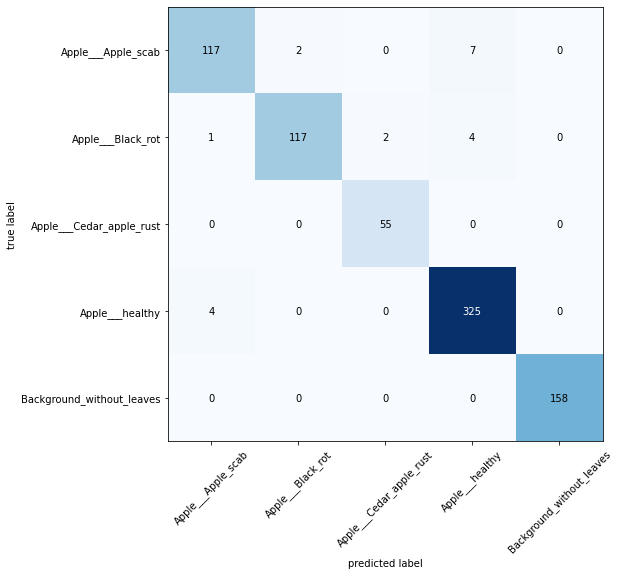

In [29]:
cs = confusion_matrix(y_true, y_pred)
cm = plot_confusion_matrix(conf_mat=cs, figsize =(8,8), class_names=class_names)